In [1]:
!nvidia-smi

Wed May 13 00:09:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1D:00.0 Off |                  N/A |
| 27%   26C    P8    13W / 250W |    955MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1E:00.0 Off |                  N/A |
| 27%   25C    P8     4W / 250W |     10MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')

from ce_utils import load_data, one_hot, test_batch_idxs
from ce_utils import model_prob
from ce_utils import classification_metric
from ce_model import binary_model, ensemble_model

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Import Model

In [3]:
nh_list = sorted([i[:-5] for i in os.listdir('./model/ENTIRE') if 'meta' in i and 'rgb_NH' in i])
nd_list = sorted([i[:-5] for i in os.listdir('./model/ENTIRE') if 'meta' in i and 'rgb_ND' in i])
b_list = sorted([i[:-5] for i in os.listdir('./model/ENTIRE') if 'meta' in i and 'rgb_B' in i])

In [4]:
nh_list

['ENTIRE_rgb_NH_1908312018_5750_val_acc_1.00_val_loss_0.001598']

In [5]:
nd_list

['ENTIRE_rgb_ND_1908302155_7140_val_acc_1.00_val_loss_0.002939']

In [6]:
b_list

['ENTIRE_rgb_B_1908242109_8570_val_acc_1.00_val_loss_0.011026']

In [7]:
nh_path = './model/ENTIRE/' + nh_list[-1]
nd_path = './model/ENTIRE/' + nd_list[-1]
b_path = './model/ENTIRE/' + b_list[-1]

NH_model = binary_model(nh_path)
ND_model = binary_model(nd_path)
E_model = ensemble_model(nh_path, nd_path)
B_model = binary_model(b_path)

W0513 00:09:42.725760 140445736711936 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


# Load Test set

In [8]:
neg_img, neg_name = load_data('test', 'n', 'neg', data = 'sm', image_ch = 'rgb', extract_name = True)
redspot_img, redspot_name = load_data('test', 'h', 'redspot', data = 'sm', image_ch = 'rgb', extract_name = True)
angio_img, angio_name = load_data('test', 'h', 'angio', data = 'sm', image_ch = 'rgb', extract_name = True)
active_img, active_name = load_data('test', 'h', 'active', data = 'sm', image_ch = 'rgb', extract_name = True)
ero_img, ero_name = load_data('test', 'd', 'ero', data = 'sm', image_ch = 'rgb', extract_name = True)
ulcer_img, ulcer_name = load_data('test', 'd', 'ulcer', data = 'sm', image_ch = 'rgb', extract_name = True)
str_img, str_name = load_data('test', 'd', 'str', data = 'sm', image_ch = 'rgb', extract_name = True)

In [9]:
neg_label = one_hot(neg_img, 0)
redspot_label = one_hot(redspot_img, 1)
angio_label = one_hot(angio_img, 1)
active_label = one_hot(active_img, 1)
ero_label = one_hot(ero_img, 1)
ulcer_label = one_hot(ulcer_img, 1)
str_label = one_hot(str_img, 1)

print("negative:",neg_img.shape, neg_label.shape)
print("red spot:",redspot_img.shape, redspot_label.shape)
print("angioectasia:",angio_img.shape, angio_label.shape)
print("active_bleeding:",active_img.shape, active_label.shape)
print("erosion:",ero_img.shape, ero_label.shape)
print("ulcer:",ulcer_img.shape, ulcer_label.shape)
print("stricture:",str_img.shape, str_label.shape)

negative: (12449, 512, 512, 3) (12449, 2)
red spot: (1112, 512, 512, 3) (1112, 2)
angioectasia: (37, 512, 512, 3) (37, 2)
active_bleeding: (858, 512, 512, 3) (858, 2)
erosion: (1476, 512, 512, 3) (1476, 2)
ulcer: (1464, 512, 512, 3) (1464, 2)
stricture: (207, 512, 512, 3) (207, 2)


In [10]:
len(redspot_name) + len(angio_name) + len(active_name)

2007

In [11]:
len(ero_name) + len(ulcer_name) + len(str_name)

3147

In [12]:
len(redspot_name) + len(angio_name) + len(active_name) + len(ero_name) + len(ulcer_name) + len(str_name)

5154

In [13]:
np.random.choice(len(neg_name), 5154)

array([ 4904,   988,  4790, ..., 10245, 10737, 10224])

In [14]:
neg2_img = neg_img[np.random.choice(len(neg_name), 5154)]

In [15]:
neg2_img.shape

(5154, 512, 512, 3)

In [16]:
neg2_label = one_hot(neg2_img, 0)

# Model Inference

In [17]:
neg_e_output, neg_nh_output, neg_nd_output = model_prob(E_model, neg_img, model_type = 'ensemble')
redspot_e_output, redspot_nh_output, redspot_nd_output = model_prob(E_model, redspot_img, model_type = 'ensemble')
angio_e_output, angio_nh_output, angio_nd_output = model_prob(E_model, angio_img, model_type = 'ensemble')
active_e_output, active_nh_output, active_nd_output = model_prob(E_model, active_img, model_type = 'ensemble')
ero_e_output, ero_nh_output, ero_nd_output = model_prob(E_model, ero_img, model_type = 'ensemble')
ulcer_e_output, ulcer_nh_output, ulcer_nd_output = model_prob(E_model, ulcer_img, model_type = 'ensemble')
str_e_output, str_nh_output, str_nd_output  = model_prob(E_model, str_img, model_type = 'ensemble')

12449 / Inference Time: 00:02:03
1112 / Inference Time: 00:00:11
37 / Inference Time: 00:00:00
858 / Inference Time: 00:00:09
1476 / Inference Time: 00:00:15
1464 / Inference Time: 00:00:15
207 / Inference Time: 00:00:03


In [18]:
neg_b_output = model_prob(B_model, neg_img)
redspot_b_output = model_prob(B_model, redspot_img)
angio_b_output = model_prob(B_model, angio_img)
active_b_output = model_prob(B_model, active_img)
ero_b_output = model_prob(B_model, ero_img)
ulcer_b_output = model_prob(B_model, ulcer_img)
str_b_output  = model_prob(B_model, str_img)

12449 / Inference Time: 00:00:59
1112 / Inference Time: 00:00:05
37 / Inference Time: 00:00:00
858 / Inference Time: 00:00:04
1476 / Inference Time: 00:00:07
1464 / Inference Time: 00:00:07
207 / Inference Time: 00:00:01


In [19]:
neg2_e_output, neg2_nh_output, neg2_nd_output = model_prob(E_model, neg2_img, model_type = 'ensemble')
neg2_b_output = model_prob(B_model, neg2_img)

5154 / Inference Time: 00:00:51
5154 / Inference Time: 00:00:25


# Evaluation

In [20]:
cls = classification_metric()

## Accuracy per lesion

In [21]:
neg_nh_acc = cls.accuracy(neg_label, neg_nh_output, lesion = 'negative')
redspot_nh_acc = cls.accuracy(redspot_label, redspot_nh_output, lesion = 'red spot')
angio_nh_acc = cls.accuracy(angio_label, angio_nh_output, lesion = 'angioectasia')
active_nh_acc = cls.accuracy(active_label, active_nh_output, lesion = 'active bleeding')
ero_nh_acc = cls.accuracy(ero_label, ero_nh_output, lesion = 'erosion')
ulcer_nh_acc = cls.accuracy(ulcer_label, ulcer_nh_output, lesion = 'ulcer')
str_nh_acc = cls.accuracy(str_label, str_nh_output, lesion = 'stricture')

negative: 97.72 %
red spot: 96.22 %
angioectasia: 100.00 %
active bleeding: 99.77 %
erosion: 87.87 %
ulcer: 84.29 %
stricture: 81.16 %


In [22]:
neg_nd_acc = cls.accuracy(neg_label, neg_nd_output, lesion = 'negative')
redspot_nd_acc = cls.accuracy(redspot_label, redspot_nd_output, lesion = 'red spot')
angio_nd_acc = cls.accuracy(angio_label, angio_nd_output, lesion = 'angioectasia')
active_nd_acc = cls.accuracy(active_label, active_nd_output, lesion = 'active bleeding')
ero_nd_acc = cls.accuracy(ero_label, ero_nd_output, lesion = 'erosion')
ulcer_nd_acc = cls.accuracy(ulcer_label, ulcer_nd_output, lesion = 'ulcer')
str_nd_acc = cls.accuracy(str_label, str_nd_output, lesion = 'stricture')

negative: 97.23 %
red spot: 81.29 %
angioectasia: 100.00 %
active bleeding: 95.45 %
erosion: 96.07 %
ulcer: 95.90 %
stricture: 97.10 %


In [23]:
neg_b_acc = cls.accuracy(neg_label, neg_b_output, lesion = 'negative')
redspot_b_acc = cls.accuracy(redspot_label, redspot_b_output, lesion = 'red spot')
angio_b_acc = cls.accuracy(angio_label, angio_b_output, lesion = 'angioectasia')
active_b_acc = cls.accuracy(active_label, active_b_output, lesion = 'active bleeding')
ero_b_acc = cls.accuracy(ero_label, ero_b_output, lesion = 'erosion')
ulcer_b_acc = cls.accuracy(ulcer_label, ulcer_b_output, lesion = 'ulcer')
str_b_acc = cls.accuracy(str_label, str_b_output, lesion = 'stricture')

negative: 98.06 %
red spot: 92.81 %
angioectasia: 100.00 %
active bleeding: 98.60 %
erosion: 95.33 %
ulcer: 94.40 %
stricture: 94.69 %


In [24]:
neg_e_acc = cls.accuracy(neg_label, neg_e_output, lesion = 'negative')
redspot_e_acc = cls.accuracy(redspot_label, redspot_e_output, lesion = 'red spot')
angio_e_acc = cls.accuracy(angio_label, angio_e_output, lesion = 'angioectasia')
active_e_acc = cls.accuracy(active_label, active_e_output, lesion = 'active bleeding')
ero_e_acc = cls.accuracy(ero_label, ero_e_output, lesion = 'erosion')
ulcer_e_acc = cls.accuracy(ulcer_label, ulcer_e_output, lesion = 'ulcer')
str_e_acc = cls.accuracy(str_label, str_e_output, lesion = 'stricture')

negative: 95.70 %
red spot: 97.48 %
angioectasia: 100.00 %
active bleeding: 99.77 %
erosion: 97.15 %
ulcer: 96.86 %
stricture: 97.58 %


In [25]:
neg2_e_acc = cls.accuracy(neg2_label, neg2_e_output, lesion = 'negative')
neg2_b_acc = cls.accuracy(neg2_label, neg2_b_output, lesion = 'negative')

negative: 95.62 %
negative: 98.16 %


In [27]:
neg2_nh_acc = cls.accuracy(neg2_label, neg2_nh_output, lesion = 'negative')

negative: 97.69 %


In [28]:
neg2_nd_acc = cls.accuracy(neg2_label, neg2_nd_output, lesion = 'negative')

negative: 97.26 %


In [29]:
neg2_b_acc = cls.accuracy(neg2_label, neg2_b_output, lesion = 'negative')

negative: 98.16 %


In [30]:
neg2_e_acc = cls.accuracy(neg2_label, neg2_e_output, lesion = 'negative')

negative: 95.62 %


## Confusion Matrix

In [67]:
nh_outputs = np.vstack([neg_nh_output, redspot_nh_output, angio_nh_output, active_nh_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label])

nh_CM = cls.con_mat(labels, nh_outputs)

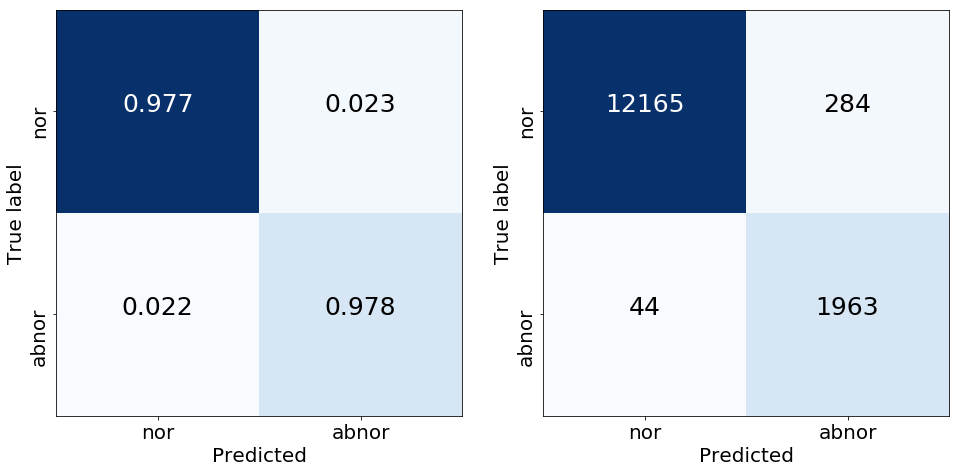

In [68]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [69]:
nh_outputs = np.vstack([neg2_nh_output, redspot_nh_output, angio_nh_output, active_nh_output])
labels = np.vstack([neg2_label, redspot_label, angio_label, active_label])

nh_CM = cls.con_mat(labels, nh_outputs)

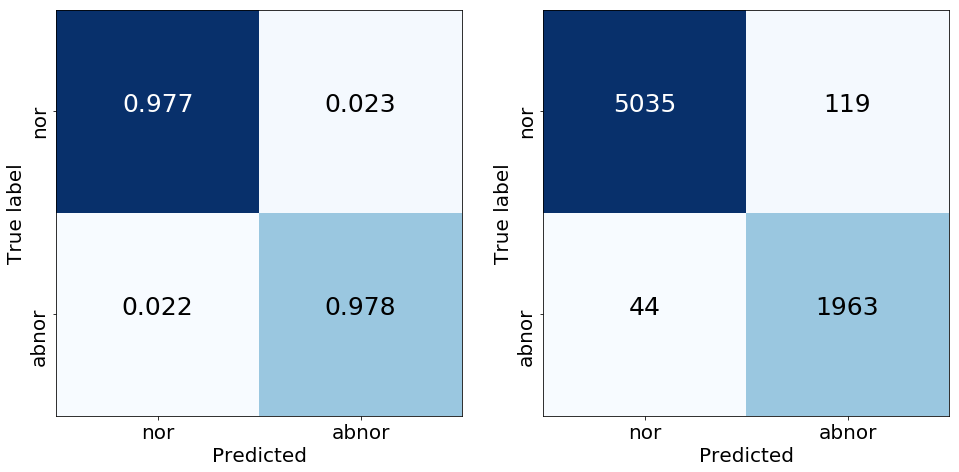

In [70]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [71]:
nd_outputs = np.vstack([neg_nd_output, ero_nd_output, ulcer_nd_output, str_nd_output])
labels = np.vstack([neg_label, ero_label, ulcer_label, str_label])

nd_CM = cls.con_mat(labels, nd_outputs)

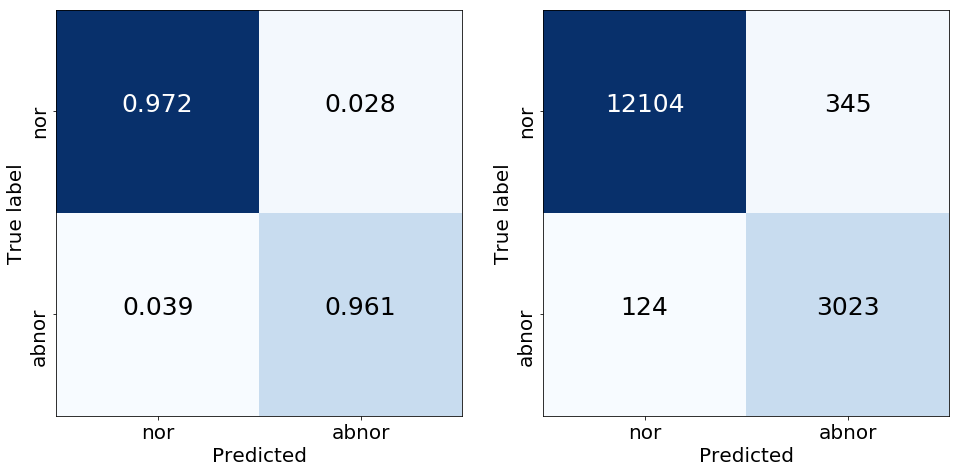

In [72]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [73]:
nd_outputs = np.vstack([neg2_nd_output, ero_nd_output, ulcer_nd_output, str_nd_output])
labels = np.vstack([neg2_label, ero_label, ulcer_label, str_label])

nd_CM = cls.con_mat(labels, nd_outputs)

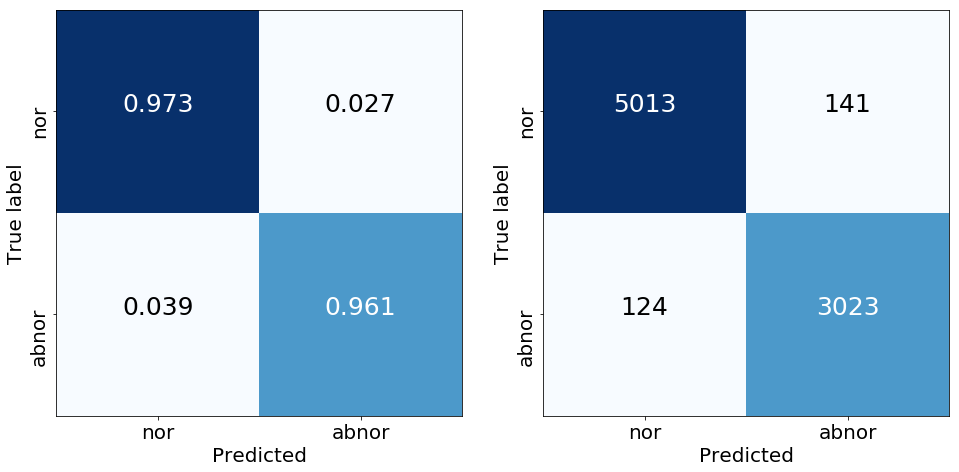

In [74]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [75]:
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_CM = cls.con_mat(labels, e_outputs)

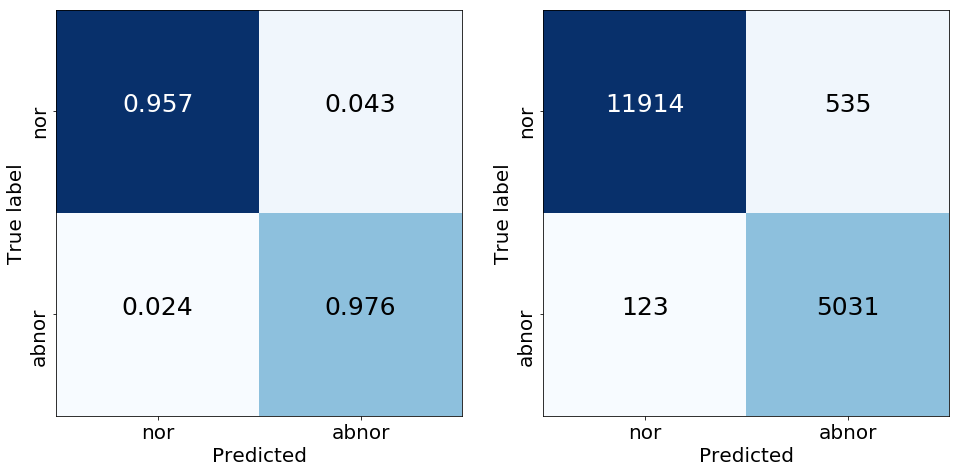

In [76]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [77]:
b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

b_CM = cls.con_mat(labels, b_outputs)

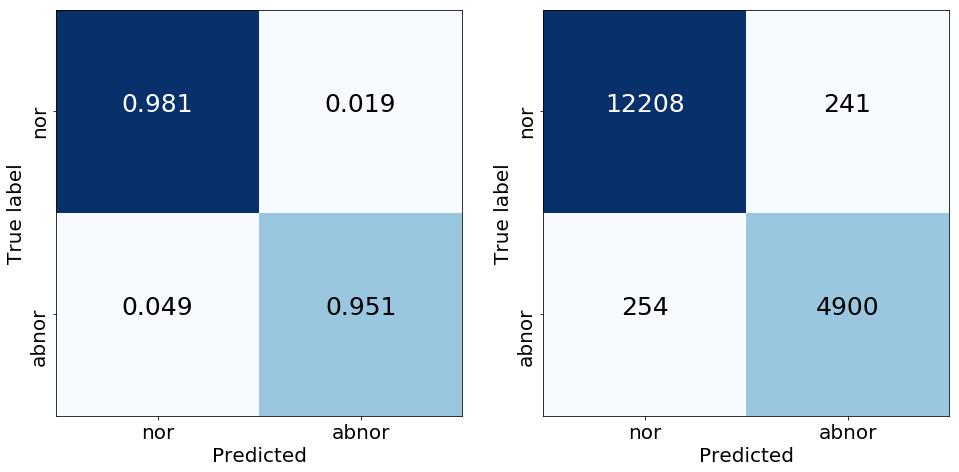

In [78]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

In [79]:
e_outputs = np.vstack([neg2_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg2_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_CM = cls.con_mat(labels, e_outputs)

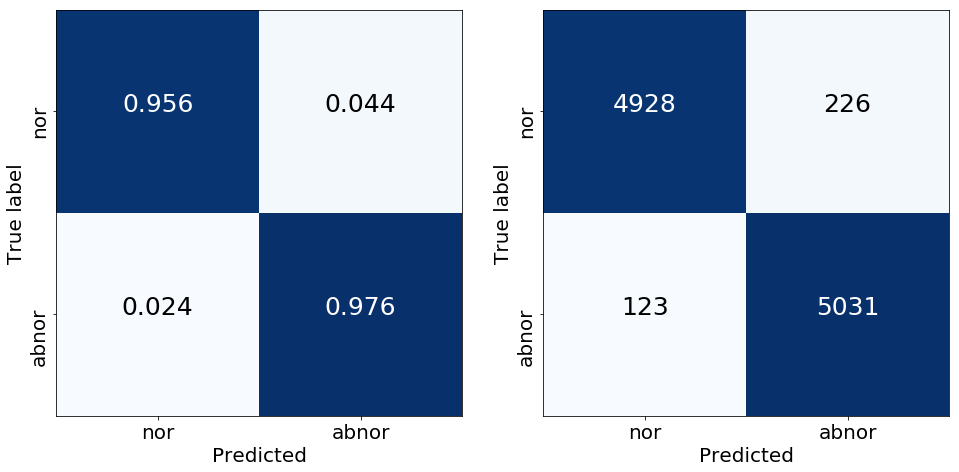

In [80]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.show()

In [81]:
b_outputs = np.vstack([neg2_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
labels = np.vstack([neg2_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

b_CM = cls.con_mat(labels, b_outputs)

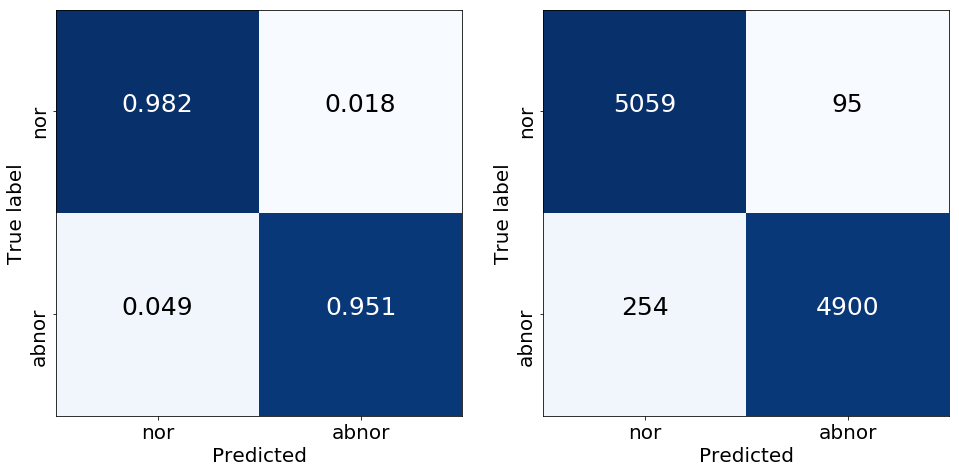

In [82]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

## ROC curve

In [31]:
from scipy.stats import sem, t
from scipy import mean

def conf_interval(data, conf_level = 0.95, mode = 'value', metric = 'Accr'):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + conf_level) / 2, n - 1)

    start = m - h
    end = m + h
    
    if mode == 'value':
        return m, start, end
    elif mode == 'print':
        return print("{} --- {:.2f} ({:.2f} ~ {:.2f})".format(metric, m, start, end))

from sklearn.model_selection import KFold

def k_fold_idx(n_fold, dataset):
    kf = KFold(n_splits = n_fold, shuffle = True)
    train_idxs = []
    test_idxs = []
    for train_idx, test_idx in kf.split(dataset):
        train_idxs.append(train_idx)
        test_idxs.append(test_idx)
    return train_idxs, test_idxs

n_g = 10

_, neg_idxs = k_fold_idx(n_fold = n_g, dataset = neg_label)
_, redspot_idxs = k_fold_idx(n_fold = n_g, dataset = redspot_label)
_, angio_idxs = k_fold_idx(n_fold = n_g, dataset = angio_label)
_, active_idxs = k_fold_idx(n_fold = n_g, dataset = active_label)
_, ero_idxs = k_fold_idx(n_fold = n_g, dataset = ero_label)
_, ulcer_idxs = k_fold_idx(n_fold = n_g, dataset = ulcer_label)
_, str_idxs = k_fold_idx(n_fold = n_g, dataset = str_label)

_, neg2_idxs = k_fold_idx(n_fold = n_g, dataset = neg2_label)

In [32]:
from sklearn.metrics import roc_curve, auc

e_aucs, b_aucs = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
    b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])
    e_aucs.append(auc(e_fpr, e_tpr))
    b_aucs.append(auc(b_fpr, b_tpr))

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


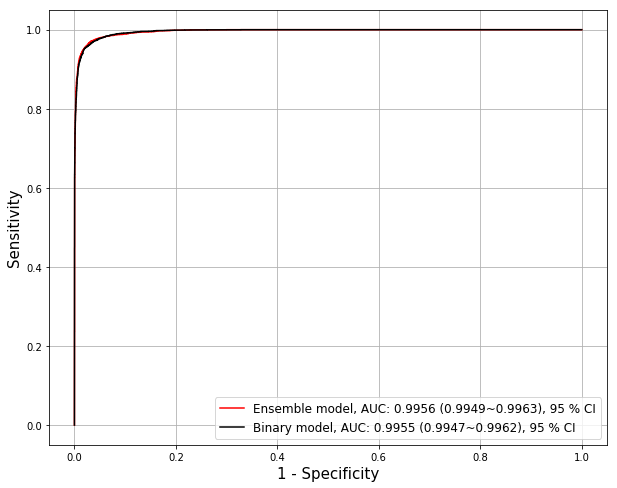

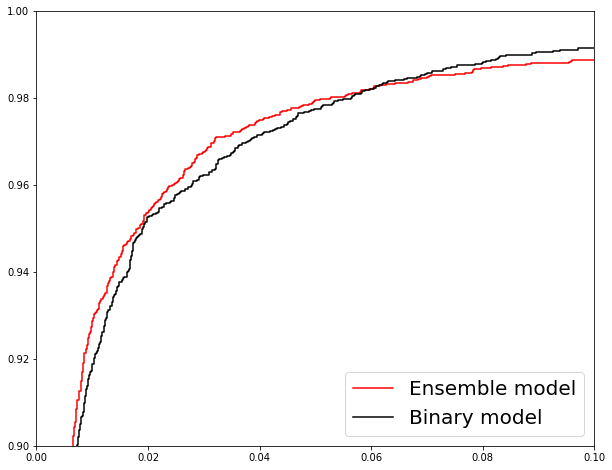

In [33]:
e_auc_m, e_auc_l, e_auc_u = conf_interval(e_aucs, mode = 'value')
b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(e_auc_m, e_auc_l, e_auc_u))
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(b_auc_m, b_auc_l, b_auc_u))
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model")
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 20, loc = 4)
fig.show()

In [57]:
e_auc_m, e_auc_l, e_auc_u = conf_interval(e_aucs, mode = 'value')
b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

In [35]:
e_gmeans = np.sqrt(e_tpr * (1-e_fpr))
e_ix = np.argmax(e_gmeans)

In [36]:
b_gmeans = np.sqrt(b_tpr * (1-b_fpr))
b_ix = np.argmax(b_gmeans)

In [54]:
e_fpr[e_ix]

0.032211422604225236

In [55]:
e_tpr[e_ix]

0.9708963911525029

In [58]:
b_tpr[b_ix]

0.9660457896779201

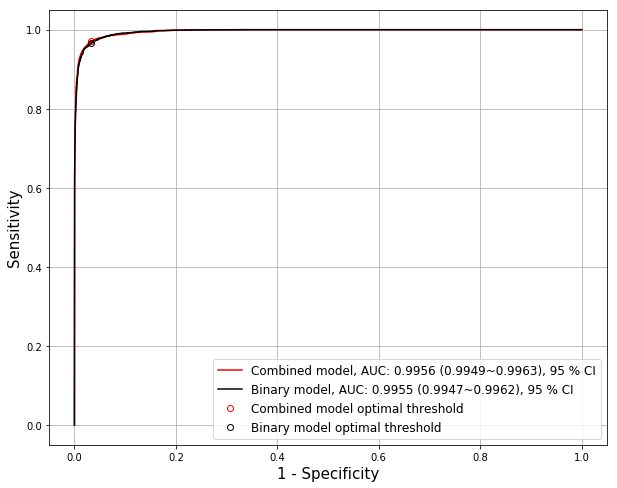

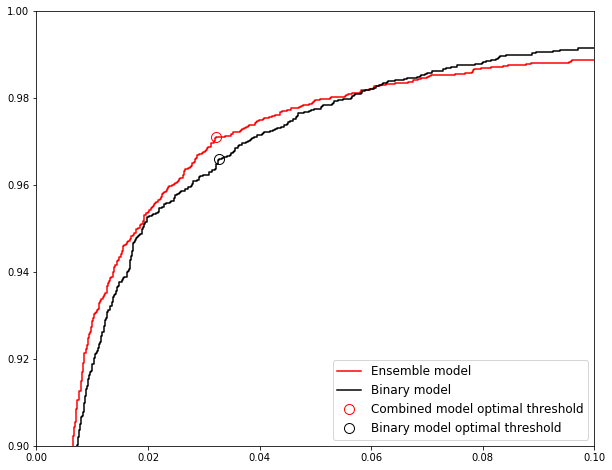

In [53]:
fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Combined model, AUC: 0.9957 (0.9951~0.9963), 95 % CI")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: 0.9956 (0.9948~0.9964), 95 % CI")
plt.plot(e_fpr[e_ix], e_tpr[e_ix], 'o', mfc = "None", mec = 'r', label = "Combined model optimal threshold" )
plt.plot(b_fpr[b_ix], b_tpr[b_ix], 'o', mfc = "None", mec = 'k', label = "Binary model optimal threshold" )
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model")
plt.plot(e_fpr[e_ix], e_tpr[e_ix], 'o', mfc = "None", mec = 'r', ms = 10, label = "Combined model optimal threshold" )
plt.plot(b_fpr[b_ix], b_tpr[b_ix], 'o', mfc = "None", mec = 'k', ms = 10, label = "Binary model optimal threshold" )
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 12, loc = 4)
fig.show()

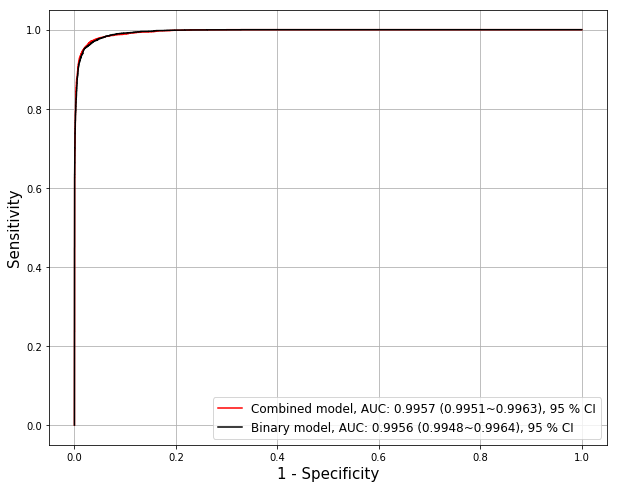

In [58]:
fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Combined model, AUC: 0.9957 (0.9951~0.9963), 95 % CI")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: 0.9956 (0.9948~0.9964), 95 % CI")
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

In [59]:
fig.savefig('./results/roc_curve (term revised).png', bbox_inches='tight', dpi = 300)

In [59]:
e_aucs, b_aucs = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg2_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg2_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg2_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg2_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
    b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])
    e_aucs.append(auc(e_fpr, e_tpr))
    b_aucs.append(auc(b_fpr, b_tpr))

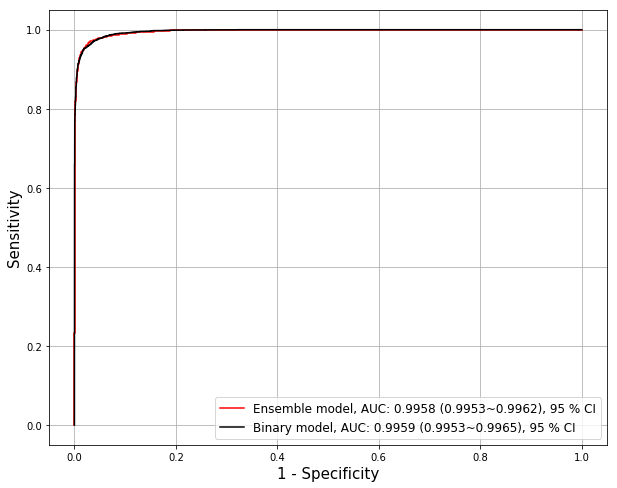

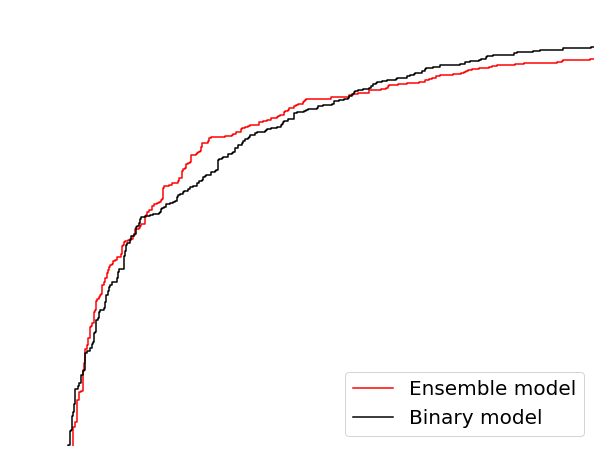

In [60]:
e_auc_m, e_auc_l, e_auc_u = conf_interval(e_aucs, mode = 'value')
b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

b_outputs = np.vstack([neg2_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
e_outputs = np.vstack([neg2_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg2_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(e_auc_m, e_auc_l, e_auc_u))
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(b_auc_m, b_auc_l, b_auc_u))
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()
# fig.savefig('./results/roc_curve.png', bbox_inches='tight', dpi = 300)
fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model")
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.axis('off')
plt.legend(fontsize = 20, loc = 4)
fig.show()
# fig.savefig('./results/roc_curve_enlarged.png', bbox_inches='tight', dpi = 300)

In [61]:
e_gmeans = np.sqrt(e_tpr * (1-e_fpr))
e_ix = np.argmax(e_gmeans)

In [62]:
b_gmeans = np.sqrt(b_tpr * (1-b_fpr))
b_ix = np.argmax(b_gmeans)

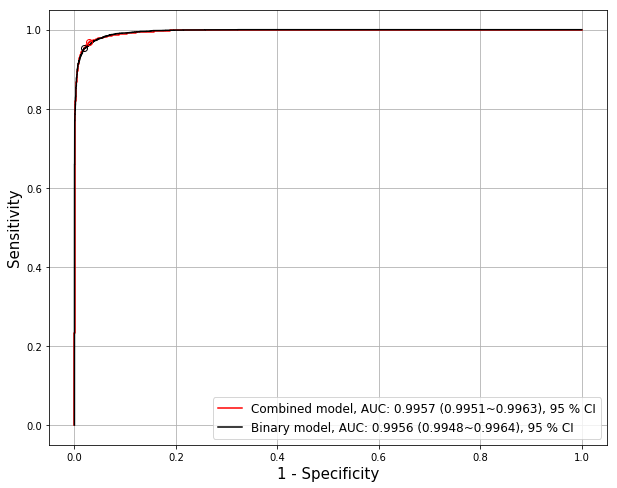

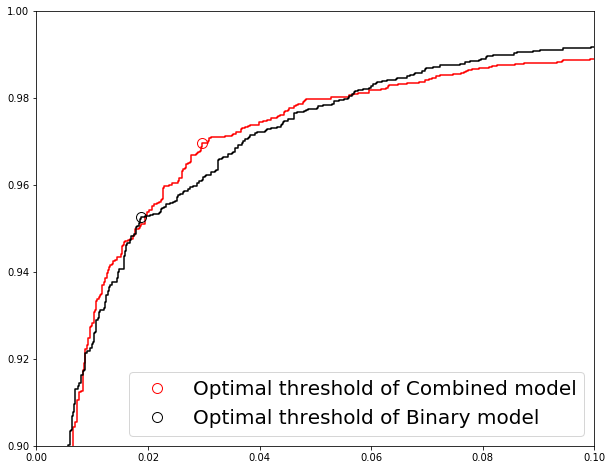

In [89]:
fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Combined model, AUC: 0.9957 (0.9951~0.9963), 95 % CI")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: 0.9956 (0.9948~0.9964), 95 % CI")
plt.plot(e_fpr[e_ix], e_tpr[e_ix], 'o', mfc = "None", mec = 'r')
plt.plot(b_fpr[b_ix], b_tpr[b_ix], 'o', mfc = "None", mec = 'k')
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()
fig.savefig('./results/roc_curve_v2.png', bbox_inches='tight', dpi = 300)
fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-')
plt.plot(b_fpr, b_tpr, 'k-')
plt.plot(e_fpr[e_ix], e_tpr[e_ix], 'o', mfc = "None", mec = 'r', ms = 10, label = "Optimal threshold of Combined model" )
plt.plot(b_fpr[b_ix], b_tpr[b_ix], 'o', mfc = "None", mec = 'k', ms = 10, label = "Optimal threshold of Binary model" )
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 20, loc = 4)
fig.show()
fig.savefig('./results/roc_curve_enlarged_v2.png', bbox_inches='tight', dpi = 300)

In [93]:
e_tpr[e_idx]

IndexError: index 987 is out of bounds for axis 0 with size 984

In [97]:
np.linspace(0, e_tpr[e_ix], 100)

array([0.        , 0.00979332, 0.01958663, 0.02937995, 0.03917326,
       0.04896658, 0.05875989, 0.06855321, 0.07834652, 0.08813984,
       0.09793315, 0.10772647, 0.11751978, 0.1273131 , 0.13710642,
       0.14689973, 0.15669305, 0.16648636, 0.17627968, 0.18607299,
       0.19586631, 0.20565962, 0.21545294, 0.22524625, 0.23503957,
       0.24483288, 0.2546262 , 0.26441952, 0.27421283, 0.28400615,
       0.29379946, 0.30359278, 0.31338609, 0.32317941, 0.33297272,
       0.34276604, 0.35255935, 0.36235267, 0.37214598, 0.3819393 ,
       0.39173262, 0.40152593, 0.41131925, 0.42111256, 0.43090588,
       0.44069919, 0.45049251, 0.46028582, 0.47007914, 0.47987245,
       0.48966577, 0.49945908, 0.5092524 , 0.51904572, 0.52883903,
       0.53863235, 0.54842566, 0.55821898, 0.56801229, 0.57780561,
       0.58759892, 0.59739224, 0.60718555, 0.61697887, 0.62677218,
       0.6365655 , 0.64635882, 0.65615213, 0.66594545, 0.67573876,
       0.68553208, 0.69532539, 0.70511871, 0.71491202, 0.72470

In [106]:
e_tpr[e_ix]

0.9695382227396198

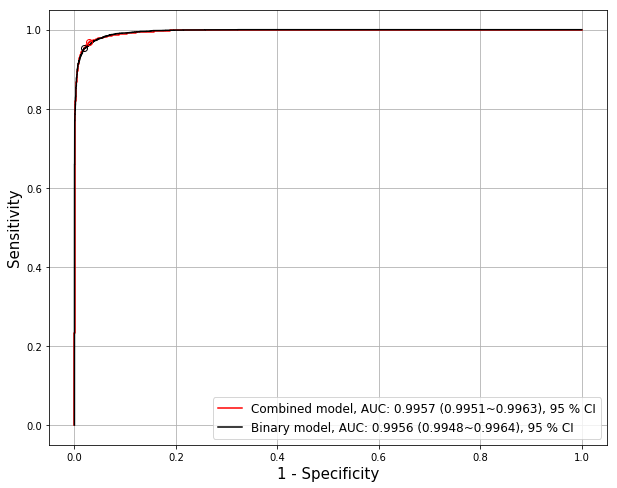

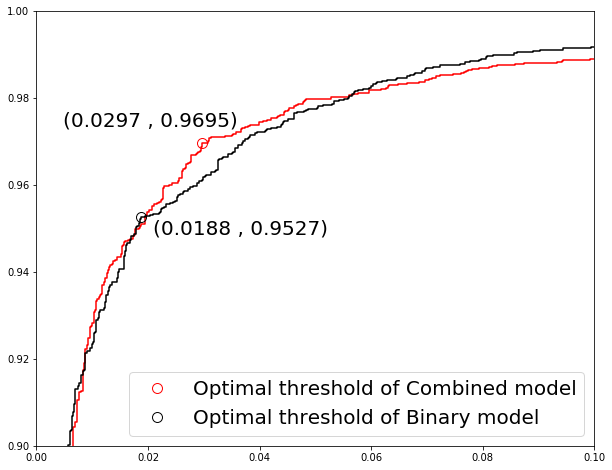

In [132]:
fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Combined model, AUC: 0.9957 (0.9951~0.9963), 95 % CI")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: 0.9956 (0.9948~0.9964), 95 % CI")
plt.plot(e_fpr[e_ix], e_tpr[e_ix], 'o', mfc = "None", mec = 'r')
# plt.plot(np.linspace(0, e_tpr[e_ix], 100), 100*[e_tpr[e_idx]], 'r--')
# plt.axvline(e_fpr[e_ix], ymin = 0.0, ymax = 0.9, linestyle = '--')
plt.plot(b_fpr[b_ix], b_tpr[b_ix], 'o', mfc = "None", mec = 'k')
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()
# fig.savefig('./results/roc_curve_v2.png', bbox_inches='tight', dpi = 300)
fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-')
plt.plot(b_fpr, b_tpr, 'k-')
plt.plot(e_fpr[e_ix], e_tpr[e_ix], 'o', mfc = "None", mec = 'r', ms = 10, label = "Optimal threshold of Combined model" )
plt.text(e_fpr[e_ix] - 0.025, e_tpr[e_ix] + 0.004, '({:.4f} , {:.4f})'.format(e_fpr[e_ix], e_tpr[e_ix]), fontsize=20)
plt.plot(b_fpr[b_ix], b_tpr[b_ix], 'o', mfc = "None", mec = 'k', ms = 10, label = "Optimal threshold of Binary model" )
plt.text(b_fpr[b_ix] + 0.002, b_tpr[b_ix] - 0.004, '({:.4f} , {:.4f})'.format(b_fpr[b_ix], b_tpr[b_ix]), fontsize=20)
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 20, loc = 4)
fig.show()
fig.savefig('./results/roc_curve_enlarged_v3.png', bbox_inches='tight', dpi = 300)

In [64]:
e_tpr[e_ix]

0.9695382227396198

In [87]:
1 - e_fpr[e_ix]

0.970314318975553

In [65]:
b_tpr[b_ix]

0.9526581296080714

In [88]:
1 - b_fpr[b_ix]

0.9811796662786185

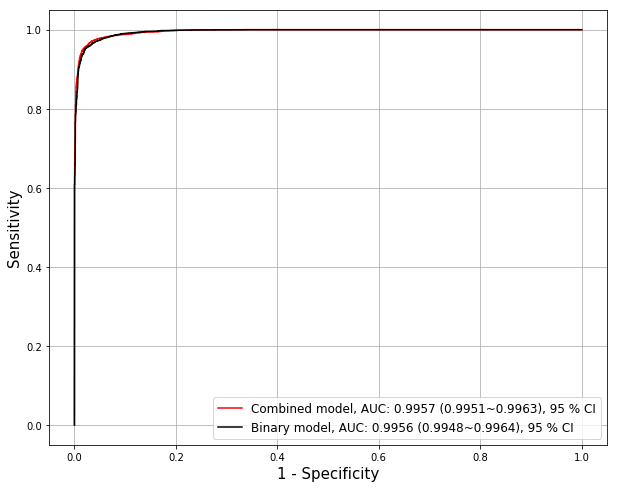

In [67]:
fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Combined model, AUC: 0.9957 (0.9951~0.9963), 95 % CI")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: 0.9956 (0.9948~0.9964), 95 % CI")
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

In [68]:
fig.savefig('./results/roc_curve (term revised).png', bbox_inches='tight', dpi = 300)

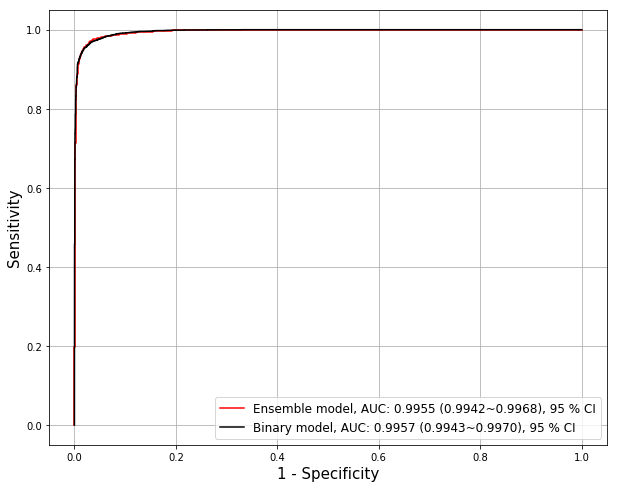

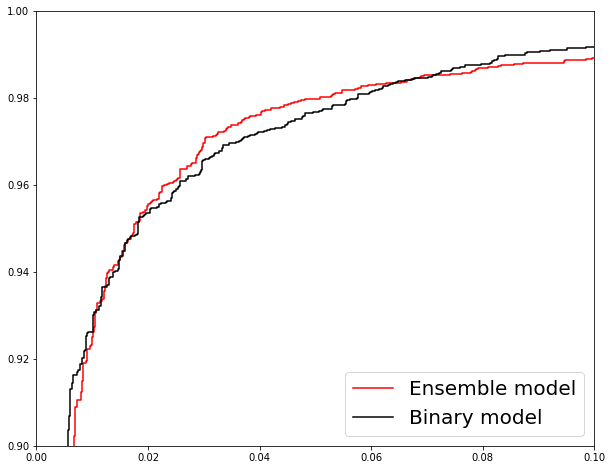

In [45]:
e_auc_m, e_auc_l, e_auc_u = conf_interval(e_aucs, mode = 'value')
b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

b_outputs = np.vstack([neg2_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
e_outputs = np.vstack([neg2_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg2_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(e_auc_m, e_auc_l, e_auc_u))
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(b_auc_m, b_auc_l, b_auc_u))
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model")
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 20, loc = 4)
fig.show()

## Statistics

![image](http://mblogthumb3.phinf.naver.net/20121114_106/istech7_1352875002440GYyqh_PNG/%B5%CE%C1%FD%B4%DC%C2%F7%C0%CC_%B0%CB%C1%A4%B9%E6%B9%FD%C8%E5%B8%A7%B5%B5.png?type=w2)

![image](https://t1.daumcdn.net/cfile/tistory/2743524658F2520C2A)

https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F1378B94E4F9C187F23

In [46]:
e_CM, b_CM = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    print(labels.shape)
    e_CM.append(cls.con_mat(labels, e_outputs)), b_CM.append(cls.con_mat(labels, b_outputs))

(1763, 2)
(1763, 2)
(1762, 2)
(1762, 2)
(1761, 2)
(1761, 2)
(1760, 2)
(1758, 2)
(1757, 2)
(1756, 2)


In [47]:
b_metrices = []
e_metrices = []

for e_cm, b_cm in zip(e_CM, b_CM):
    b_metrices.append(cls.cm2metric(b_cm))
    e_metrices.append(cls.cm2metric(e_cm))
    
b_metrices = np.asarray(b_metrices)
e_metrices = np.asarray(e_metrices)

In [48]:
b_metrices

array([[0.9733409 , 0.96138996, 0.97831325, 0.98384491, 0.94857143],
       [0.97277368, 0.94980695, 0.98232932, 0.97918335, 0.95719844],
       [0.96992054, 0.94197292, 0.9815261 , 0.97603834, 0.95490196],
       [0.97162316, 0.95938104, 0.97670683, 0.98302344, 0.9447619 ],
       [0.97331062, 0.96124031, 0.97831325, 0.98384491, 0.94837476],
       [0.96763203, 0.94379845, 0.97751004, 0.97672552, 0.94563107],
       [0.97215909, 0.94951456, 0.9815261 , 0.97916667, 0.95507812],
       [0.96700796, 0.93177388, 0.9815261 , 0.97215593, 0.95409182],
       [0.97894138, 0.9609375 , 0.98634538, 0.98397436, 0.96660118],
       [0.97209567, 0.94726562, 0.98231511, 0.97838271, 0.9566075 ]])

In [49]:
e_metrices

array([[0.96880318, 0.97683398, 0.96546185, 0.99011532, 0.92167577],
       [0.95745888, 0.96525097, 0.95421687, 0.98507463, 0.89766607],
       [0.96424518, 0.9729207 , 0.96064257, 0.98842975, 0.91123188],
       [0.96481271, 0.98452611, 0.95662651, 0.99332777, 0.90408526],
       [0.96308915, 0.98255814, 0.95502008, 0.99248748, 0.90053286],
       [0.959682  , 0.97674419, 0.95261044, 0.98998331, 0.89520426],
       [0.95625   , 0.97475728, 0.94859438, 0.98911223, 0.8869258 ],
       [0.95904437, 0.96296296, 0.95742972, 0.98431049, 0.90310786],
       [0.96755834, 0.98242188, 0.96144578, 0.99253731, 0.91288566],
       [0.96526196, 0.98242188, 0.95819936, 0.99250624, 0.90630631]])

In [50]:
print("95 % CI\n")

print('Binary model')
conf_interval(100*b_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*b_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*b_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*b_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*b_metrices[:, 4], mode = 'print', metric = 'PPV')
print('')
print('Ensemble model')
conf_interval(100*e_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*e_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*e_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*e_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*e_metrices[:, 4], mode = 'print', metric = 'PPV')

95 % CI

Binary model
Accr --- 97.19 (96.95 ~ 97.43)
Sen --- 95.07 (94.35 ~ 95.79)
Spec --- 98.06 (97.86 ~ 98.27)
NPV --- 97.96 (97.68 ~ 98.25)
PPV --- 95.32 (94.85 ~ 95.79)

Ensemble model
Accr --- 96.26 (95.95 ~ 96.57)
Sen --- 97.61 (97.08 ~ 98.14)
Spec --- 95.70 (95.36 ~ 96.05)
NPV --- 98.98 (98.75 ~ 99.20)
PPV --- 90.40 (89.69 ~ 91.10)


In [51]:
e_CM, b_CM = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg2_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg2_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg2_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg2_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    print(labels.shape)
    e_CM.append(cls.con_mat(labels, e_outputs)), b_CM.append(cls.con_mat(labels, b_outputs))

(1034, 2)
(1034, 2)
(1033, 2)
(1033, 2)
(1031, 2)
(1031, 2)
(1030, 2)
(1028, 2)
(1027, 2)
(1027, 2)


In [52]:
b_metrices = []
e_metrices = []

for e_cm, b_cm in zip(e_CM, b_CM):
    b_metrices.append(cls.cm2metric(b_cm))
    e_metrices.append(cls.cm2metric(e_cm))
    
b_metrices = np.asarray(b_metrices)
e_metrices = np.asarray(e_metrices)

In [53]:
b_metrices

array([[0.97195358, 0.96138996, 0.98255814, 0.96204934, 0.98224852],
       [0.97001934, 0.94980695, 0.99031008, 0.95158287, 0.98993964],
       [0.96030978, 0.94197292, 0.97868217, 0.94392523, 0.97791165],
       [0.97095837, 0.95938104, 0.98255814, 0.96022727, 0.98217822],
       [0.96702231, 0.96124031, 0.97281553, 0.96161228, 0.97254902],
       [0.96605238, 0.94379845, 0.98834951, 0.94609665, 0.98782961],
       [0.96990291, 0.94951456, 0.99029126, 0.95149254, 0.98987854],
       [0.95428016, 0.93177388, 0.97669903, 0.93494424, 0.9755102 ],
       [0.97176241, 0.9609375 , 0.98252427, 0.96197719, 0.98203593],
       [0.9600779 , 0.94726562, 0.97281553, 0.94886364, 0.97194389]])

In [54]:
e_metrices

array([[0.97485493, 0.97683398, 0.97286822, 0.9766537 , 0.97307692],
       [0.96518375, 0.96525097, 0.96511628, 0.96511628, 0.96525097],
       [0.96708616, 0.9729207 , 0.96124031, 0.97254902, 0.96175908],
       [0.9767667 , 0.98452611, 0.96899225, 0.98425197, 0.96952381],
       [0.97187197, 0.98255814, 0.96116505, 0.98214286, 0.96204934],
       [0.97090204, 0.97674419, 0.96504854, 0.97642436, 0.96551724],
       [0.97281553, 0.97475728, 0.97087379, 0.97465887, 0.97098646],
       [0.95330739, 0.96296296, 0.94368932, 0.96237624, 0.94455067],
       [0.9707887 , 0.98242188, 0.9592233 , 0.98210736, 0.95992366],
       [0.95910419, 0.98242188, 0.93592233, 0.98167006, 0.93843284]])

In [55]:
print("95 % CI\n")

print('Binary model')
conf_interval(100*b_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*b_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*b_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*b_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*b_metrices[:, 4], mode = 'print', metric = 'PPV')
print('')
print('Ensemble model')
conf_interval(100*e_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*e_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*e_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*e_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*e_metrices[:, 4], mode = 'print', metric = 'PPV')

95 % CI

Binary model
Accr --- 96.62 (96.19 ~ 97.06)
Sen --- 95.07 (94.35 ~ 95.79)
Spec --- 98.18 (97.71 ~ 98.64)
NPV --- 95.23 (94.57 ~ 95.89)
PPV --- 98.12 (97.64 ~ 98.60)

Ensemble model
Accr --- 96.83 (96.30 ~ 97.35)
Sen --- 97.61 (97.08 ~ 98.14)
Spec --- 96.04 (95.19 ~ 96.89)
NPV --- 97.58 (97.05 ~ 98.11)
PPV --- 96.11 (95.31 ~ 96.92)


### Equal-Variance Test

In [56]:
from scipy.stats import bartlett

accr_stats = bartlett(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = bartlett(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = bartlett(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = bartlett(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = bartlett(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("bartlett test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("bartlett test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("bartlett test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("bartlett test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("bartlett test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

bartlett test for accuracy: 0.302, pvalue=0.582573523282
bartlett test for sensitivity: 0.751, pvalue=0.386124599060
bartlett test for specificity: 2.835, pvalue=0.092231496312
bartlett test for negative predictive values: 0.398, pvalue=0.528176466539
bartlett test for positive predictive values: 2.214, pvalue=0.136726391902


In [57]:
from scipy.stats import levene

accr_stats = levene(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = levene(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = levene(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = levene(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = levene(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("levene test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("levene test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("levene test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("levene test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("levene test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

levene test for accuracy: 0.049, pvalue=0.827578248289
levene test for sensitivity: 0.928, pvalue=0.348081308582
levene test for specificity: 1.078, pvalue=0.312807710531
levene test for negative predictive values: 0.558, pvalue=0.464544070961
levene test for positive predictive values: 0.792, pvalue=0.385211936993


### Normality Test

In [58]:
from scipy.stats import ks_2samp

accr_stats = ks_2samp(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ks_2samp(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ks_2samp(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ks_2samp(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ks_2samp(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("Kolmogorov-Smirnov test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("Kolmogorov-Smirnov test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("Kolmogorov-Smirnov test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("Kolmogorov-Smirnov test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("Kolmogorov-Smirnov test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

Kolmogorov-Smirnov test for accuracy: 0.300, pvalue=0.786929788478
Kolmogorov-Smirnov test for sensitivity: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for specificity: 0.900, pvalue=0.000216501764
Kolmogorov-Smirnov test for negative predictive values: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for positive predictive values: 0.900, pvalue=0.000216501764


### Wilcoxon signed-ranks test (not normal and paired group)

In [59]:
from scipy.stats import wilcoxon

accr_stats = wilcoxon(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = wilcoxon(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = wilcoxon(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = wilcoxon(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = wilcoxon(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("wilcoxon signed-ranks test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("wilcoxon signed-ranks test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("wilcoxon signed-ranks test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("wilcoxon signed-ranks test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("wilcoxon signed-ranks test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

wilcoxon signed-ranks test for accuracy: 12.000, pvalue=0.113893310627
wilcoxon signed-ranks test for sensitivity: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for specificity: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for negative predictive values: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for positive predictive values: 0.000, pvalue=0.005062032126


### Paired two-sample t-Test (normal and paired group)

In [60]:
from scipy.stats import ttest_rel

accr_stats = ttest_rel(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ttest_rel(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ttest_rel(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ttest_rel(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ttest_rel(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("t-statistics for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("t-statistics for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("t-statistics for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("t-statistics for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("t-statistics for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

t-statistics for accuracy: -1.703, pvalue=0.122804752416
t-statistics for sensitivity: -11.415, pvalue=0.000001177334
t-statistics for specificity: 7.602, pvalue=0.000033184194
t-statistics for negative predictive values: -11.537, pvalue=0.000001075527
t-statistics for positive predictive values: 7.707, pvalue=0.000029780834


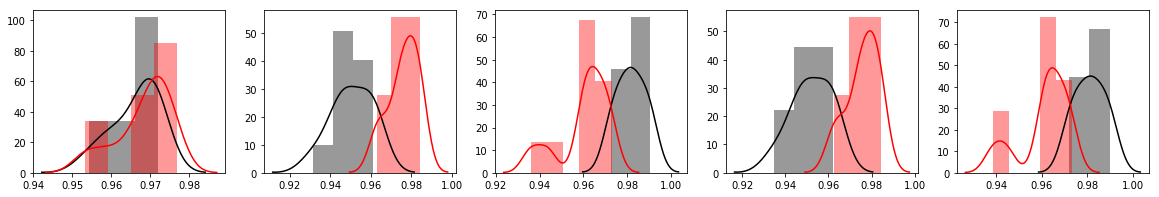

In [61]:
## Distribution by metric

import seaborn as sns

fig, axes = plt.subplots(ncols = 5)
fig.set_size_inches(20, 3)

sns.set_style({'axes.grid' : True})

sns.distplot(b_metrices[:, 0], color='k', ax = axes[0])
sns.distplot(e_metrices[:, 0], color='r', ax = axes[0])
sns.distplot(b_metrices[:, 1], color='k', ax = axes[1])
sns.distplot(e_metrices[:, 1], color='r', ax = axes[1])
sns.distplot(b_metrices[:, 2], color='k', ax = axes[2])
sns.distplot(e_metrices[:, 2], color='r', ax = axes[2])
sns.distplot(b_metrices[:, 3], color='k', ax = axes[3])
sns.distplot(e_metrices[:, 3], color='r', ax = axes[3])
sns.distplot(b_metrices[:, 4], color='k', ax = axes[4])
sns.distplot(e_metrices[:, 4], color='r', ax = axes[4])

fig.show()